In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *

# QNUM

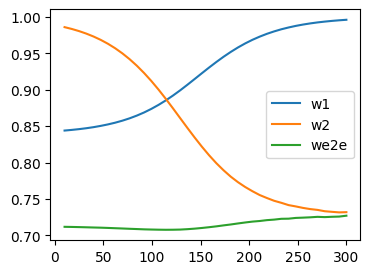

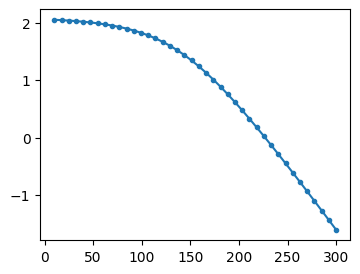

In [292]:
β = 0.2 # dB/km fiber decay rate
η = lambda x: 10**(-0.1*β*x) # fiber decay as a function of fiber length x
c = 0.1 # various other inefficiencies
d = lambda L,T: 3*c*η(L/2)/(2*T)
# T = 1e-3 # sec repetition time for entanglement generation
L1 = 15 # km distance
L3 = L1 # km distance
T1 = 1e-3 # sec repetition time for entanglement generation
T3 = T1 
d1 = d(L1,T1)
d3 = d(L3,T3)

def entropy(x):
    y = np.zeros(len(x))
    for i,x_val in enumerate(x):
        if x_val>0:
            y[i]=-x_val*np.log2(x_val)-(1-x_val)*np.log2(1-x_val)
    return y

def D_H(x):
    y = np.zeros(len(x))
    for i,x_val in enumerate(x):
        if x_val>0:
            y[i]=1+x_val*np.log2(x_val)+(1-x_val)*np.log2((1-x_val)/3)
    return y

L2_list = np.linspace(10,300,40) # km distance
# L2_list = [10]
w_opt = np.zeros(len(L2_list))
w2_opt = np.zeros(len(L2_list))
U_opt = np.zeros(len(L2_list))
T2 = 1e-4 # sec repetition time for entanglement generation

w1_list = np.linspace(0.5,1,10000) # mesh grid optimization
R_list = d1*(1-w1_list)
for i_L, L2 in enumerate(L2_list):
    d2 = d(L2,T2)
    w2 = 1- d1/d2*(1-w1_list)
    w1 = w1_list[w2>0]
    R = R_list[w2>0]
    w2 = w2[w2>0]
    
#     log_arg = R*(3* w1**2 *w2 - 1)    
#     w1_grid = w1[log_arg>0]
# #     print(np.size(w1_grid),L2)
#     log_arg = log_arg[log_arg>0]
#     U_neg = np.log(log_arg)

#     log_arg = R*(1-2*entropy((1-w1**2 * w2)/2) ) # SKF
#     log_arg = R*D_H((3* w1**2 *w2 + 1)/4 )
#     log_arg = R*(3* w1**2 *w2 - 1) #  neg
    log_arg = R*np.log((3* w1**2 *w2 + 1)/2) # log neg
    w1_grid = w1[log_arg>0]
    log_arg = log_arg[log_arg>0]
    U_neg = np.log(log_arg)
#     print(len(U_neg))
    ind_opt = np.argmax(U_neg)
    w_opt[i_L] = w1_grid[ind_opt]
    w2_opt[i_L] = 1- d1/d2*(1-w_opt[i_L])
    U_opt[i_L] = U_neg[ind_opt]
#     R_opt = d1* (1-w_opt[i_L])
#     plt.plot((3*w1_grid+1)/4,U_neg)
#     plt.plot((3*w_opt[i_L]+1)/4,U_opt,"o")
plt.figure(figsize=(4,3))
# plt.plot(L2_list,w_opt,".-",label="w1")
# plt.plot(L2_list,w2_opt,".-",label="w2")
plt.plot(L2_list,(3*w_opt+1)/4,"-",label="w1")
plt.plot(L2_list,(3*w2_opt+1)/4,"-",label="w2")
plt.plot(L2_list,(3*w_opt**2 * w2_opt+1)/4,"-",label="we2e")
plt.legend()
plt.show()

plt.figure(figsize=(4,3))
plt.plot(L2_list,U_opt,".-")
plt.show()

# print("opt link fidelity: ", (3*w_opt[i_L]+1)/4)
# print("opt utility:", U_opt)
# print("opt rate:", R_opt)


In [49]:
entropy(np.array([2.0]))

/var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/ipykernel_14213/3174086439.py:17: RuntimeWarning: invalid value encountered in log2
  y[i]=-x_val*np.log2(x_val)-(1-x_val)*np.log2(1-x_val)


array([2.])

# swap scheduling

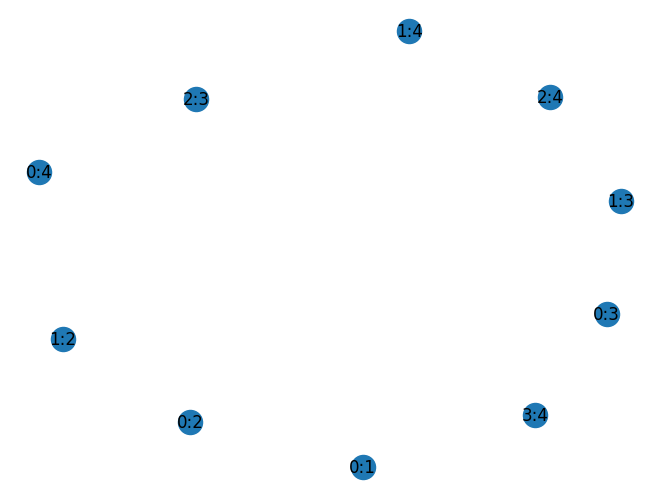

In [46]:

N = 5# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))
G.add_edges_from([(q,q+1) for q in range(N-1)])
# plt.figure(figsize=(4,3))
# nx.draw(G,  with_labels=True)
# plt.show()
adj_mat = nx.to_numpy_array(G)

Eflow = nx.Graph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow.add_node("%d:%d" % (n1,n2))
            
nx.draw(Eflow,  with_labels=True)
plt.show()

            

# N=3

In [4]:
p = 0.5
q = 0.2

m = Model()
Ef_size = int(N*(N-1)/2)
f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")
# net.setObjective(3*x1 + 2*x2 , GRB.MAXIMIZE)
rt=m.addVar(vtype=GRB.CONTINUOUS,name="rt") 
m.setObjective(rt, GRB.MAXIMIZE) 
Ist = q*(f[0][1]+f[1][2])/2
m.addConstr(rt== Ist, name="c1") 
m.addConstr(p  >= (f[0][1]+f[0][2]), name="c2") 
m.addConstr(p  >= (f[0][2]+f[1][2]), name="c3") 
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))
# print('Obj: %g' % m.ObjVal)

f_opt = np.zeros((Ef_size,Ef_size))
for v in m.getVars():
    print('%s %g' % (v.VarName, v.X))
    v.VarName

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3 rows, 10 columns and 7 nonzeros
Model fingerprint: 0x3ca5a4da
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e-01]
Presolve removed 3 rows and 10 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.000000000e-01
f[0,0] 0
f[0,1] 0.5
f[0,2] 0
f[1,0] 0
f[1,1] 0
f[1,2] 0.5
f[2,0] 0
f[2,1] 0
f[2,2] 0
rt 0.1
Obj: 0.1


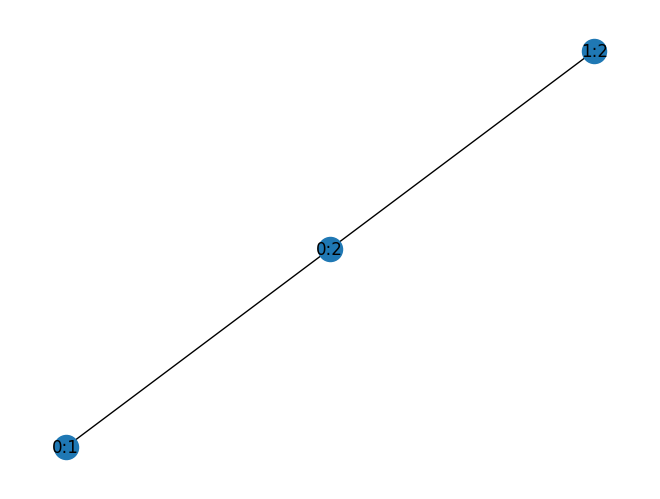

In [36]:
Ef_nodes = list(Eflow.nodes())
for i in range(Ef_size):
    for j in range(i+1,Ef_size):
#         print([i,j],m.getVars()[i*Ef_size+j].X)
        if m.getVars()[i*Ef_size+j].X > 0:
#             print((Ef_nodes[i],Ef_nodes[j]))
            Eflow.add_edge(Ef_nodes[i],Ef_nodes[j])
nx.draw(Eflow,  with_labels=True)
plt.show()


# N = 4

In [3]:
p1 = 0.5
p2 = 0.5
q = 0.1
N = 4

# indices: (superscript, subscript)
m = Model()
Ef_size = int(N*(N-1)/2)
f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")
# rt=m.addVar(vtype=GRB.CONTINUOUS,name="rt") 
# m.setObjective(rt, GRB.MAXIMIZE) 
Ist = q*(f[0][2]+f[4][2]+f[1][2]+f[5][2])/2
m.setObjective(Ist , GRB.MAXIMIZE)
# m.addConstr(rt== Ist, name="c1") 
m.addConstr(p1 +q*(f[1][0]+f[3][0])/2 >= (f[0][1]+f[0][3]+f[0][2]+f[0][4]), name="c1") 
m.addConstr( q*(f[0][1]+f[3][1])/2 >= (f[1][0]+f[1][3]+f[1][2]+f[1][5]), name="c2") 
m.addConstr(p2 +q*(f[0][3]+f[1][3]+f[4][3]+f[5][3])/2 >= (f[3][0]+f[3][1]+f[3][4]+f[3][5]), name="c3") 
m.addConstr( q*(f[3][4]+f[5][4])/2 >= (f[4][3]+f[4][5]+f[4][2]+f[4][0]), name="c4") 
m.addConstr(p1 +q*(f[3][5]+f[4][5])/2 >= (f[5][3]+f[5][4]+f[5][2]+f[5][1]), name="c5") 

m.addConstr( f[0][2]==f[4][2] )
m.addConstr( f[1][2]==f[5][2] )

m.addConstr( f[1][0]==f[3][0] , name="c6") 
m.addConstr( f[0][1]==f[3][1] , name="c7") 
m.addConstr( f[0][3]==f[1][3] , name="c8") 
m.addConstr( f[4][3]==f[5][3] , name="c9") 
m.addConstr( f[3][4]==f[5][4] , name="c10") 
m.addConstr( f[3][5]==f[4][5] , name="c11")

m.addConstr( f[2][0]==0) 
m.addConstr( f[2][1]==0) 
m.addConstr( f[2][4]==0) 
m.addConstr( f[2][5]==0) 

m.addConstr( f[4][0]==0) 
m.addConstr( f[5][1]==0) 
m.addConstr( f[0][4]==0) 
m.addConstr( f[1][5]==0) 

m.optimize()

# f_opt = np.zeros((Ef_size,Ef_size))
# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))
#     v.VarName

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21 rows, 36 columns and 56 nonzeros
Model fingerprint: 0x64de0d27
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e-01]
Presolve removed 16 rows and 28 columns
Presolve time: 0.01s
Presolved: 5 rows, 8 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+29   3.100000e+30   2.000000e-01      0s
       5    5.0000000e-03   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.000000000e-03


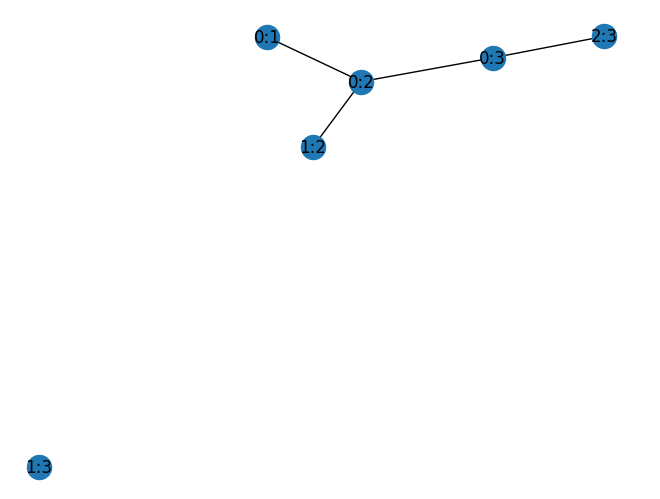

In [4]:
Eflow = nx.Graph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow.add_node("%d:%d" % (n1,n2))

Ef_nodes = list(Eflow.nodes())
for i in range(Ef_size):
    for j in range(Ef_size):
#         print([i,j],m.getVars()[i*Ef_size+j].X)
        if m.getVars()[i*Ef_size+j].X > 0:
#             print((Ef_nodes[i],Ef_nodes[j]))
            Eflow.add_edge(Ef_nodes[i],Ef_nodes[j])
nx.draw(Eflow,  with_labels=True)
plt.show()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 21 rows, 36 columns and 56 nonzeros
Model fingerprint: 0xd33eff61
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 5e-01]
Presolve removed 16 rows and 28 columns
Presolve time: 0.01s
Presolved: 5 rows, 8 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+29   3.100000e+30   2.000000e-01      0s
       5    5.0000000e-03   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.000000000e-03


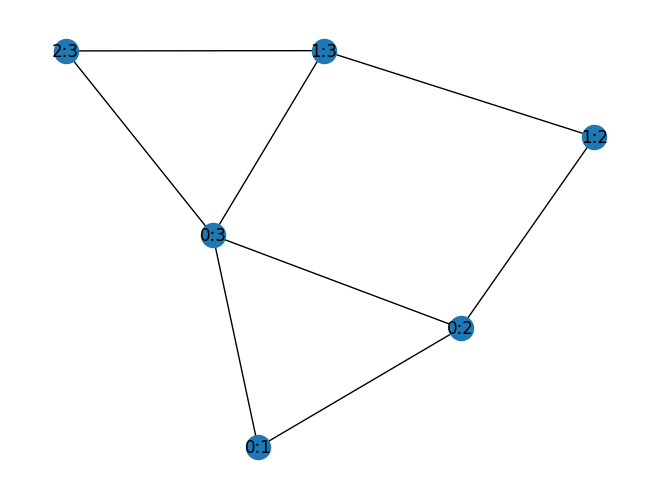

In [25]:
N = 4# number of nodes
G = nx.Graph()
G.add_nodes_from(np.arange(N))
G.add_edges_from([(q,q+1) for q in range(N-1)])
# plt.figure(figsize=(4,3))
# nx.draw(G,  with_labels=True)
# plt.show()
adj_mat = nx.to_numpy_array(G)

Eflow = nx.Graph()
for n1 in range(N):
    for n2 in range(n1+1,N):
        Eflow.add_node("%d:%d" % (n1,n2))
            
            
p1 = 0.4
p2 = 0.5
q = 0.1
p_list = p1* np.ones(N)
p_list[1] = p2

# indices: (superscript, subscript)
m = Model()
Ef_size = int(N*(N-1)/2)
f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")

Ef_nodes = np.array(list(Eflow.nodes()))
s = "0"
t = "%d" % (N-1)
st = np.argwhere(Ef_nodes== s+":"+t ) [0][0]

for n1 in range(N):
    for n2 in range(n1+1,N):
        
        ab = np.argwhere(Ef_nodes== "%d:%d" % (n1,n2) ) [0][0]
        if ab == st:    
            Ist = 0
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
#                     print([ac,ab],[bc,ab])
                    Ist += q*(f[ac][ab]+f[bc][ab])/2
                    m.addConstr( f[ac][ab]==f[bc][ab] ) 
                    
            m.setObjective(Ist , GRB.MAXIMIZE)

        else:
    #         print([n1,n2],e1)
            if n2 == n1+1:
                lhs = p_list[n1]
            else:
                lhs = 0
            rhs = 0
            for n3 in range(N):
                if n3 not in [n1,n2]:
                    ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                    bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                    rhs += f[ab][ac]+f[ab][bc]
                    
                    if ac == st or bc == st:
#                         print([bc,ab],[ac,ab])
                        m.addConstr( f[bc][ab]==0 ) 
                        m.addConstr( f[ac][ab]==0 ) 
                    else:
#                         print([ac,ab],[bc,ab])
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 
                        lhs += q*(f[ac][ab]+f[bc][ab])/2
                    
            m.addConstr(lhs >= rhs ) 
        
m.optimize()

# f_opt = np.zeros((Ef_size,Ef_size))
# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))
#     v.VarName

# Ef_nodes = list(Eflow.nodes())
for i in range(Ef_size):
    for j in range(Ef_size):
#         print([i,j],m.getVars()[i*Ef_size+j].X)
        if m.getVars()[i*Ef_size+j].X > 0:
#             print(m.getVars()[i*Ef_size+j].X)
#             print((Ef_nodes[i],Ef_nodes[j]))
            Eflow.add_edge(Ef_nodes[i],Ef_nodes[j])
        elif m.getVars()[i*Ef_size+j].X < 0:
            print(m.getVars()[i*Ef_size+j].X)

nx.draw(Eflow,  with_labels=True)

# components = [Eflow.subgraph(c).copy() for c in nx.connected_components(Eflow)]
# nx.draw(components[0],  with_labels=True)
plt.show()
# print(m.ObjVal)

In [26]:
f_opt = np.zeros((Ef_size,Ef_size))
# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))
for i in range(Ef_size):
    for j in range(Ef_size):
        if m.getVars()[i*Ef_size+j].X > 0:
            print([Ef_nodes[i],Ef_nodes[j]],m.getVars()[i*Ef_size+j].X)
            f_opt[i,j] = m.getVars()[i*Ef_size+j].X

['0:1', '0:2'] 0.11111111111111109
['0:1', '0:3'] 0.03888888888888889
['0:2', '0:3'] 0.011111111111111113
['1:2', '0:2'] 0.11111111111111109
['1:2', '1:3'] 0.3888888888888889
['1:3', '0:3'] 0.03888888888888889
['2:3', '0:3'] 0.011111111111111127
['2:3', '1:3'] 0.3888888888888889


## Monte Carlo Simulation

In [29]:

def rate_p(p1=0.5,p2=0.5,q=0.4):

    p_list = p1* np.ones(N)
    p_list[1] = p2

    # indices: (superscript, subscript)
    m = Model()
    f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")

    Eflow = nx.Graph()
    for n1 in range(N):
        for n2 in range(n1+1,N):
            Eflow.add_node("%d:%d" % (n1,n2))
    Ef_nodes = np.array(list(Eflow.nodes()))
    s = "0"
    t = "%d" % (N-1)
    st = np.argwhere(Ef_nodes== s+":"+t ) [0][0]

    for n1 in range(N):
        for n2 in range(n1+1,N):

            ab = np.argwhere(Ef_nodes== "%d:%d" % (n1,n2) ) [0][0]
            if ab == st:    
                Ist = 0
                for n3 in range(N):
                    if n3 not in [n1,n2]:
                        ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                        bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                        Ist += q*(f[ac][ab]+f[bc][ab])/2
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 

                m.setObjective(Ist , GRB.MAXIMIZE)

            else:
                if n2 == n1+1:
                    lhs = p_list[n1]
                else:
                    lhs = 0
                rhs = 0
                for n3 in range(N):
                    if n3 not in [n1,n2]:
                        ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                        bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                        rhs += f[ab][ac]+f[ab][bc]

                        if ac == st or bc == st:
                            m.addConstr( f[bc][ab]==0 ) 
                            m.addConstr( f[ac][ab]==0 ) 
                        else:
                            m.addConstr( f[ac][ab]==f[bc][ab] ) 
                            lhs += q*(f[ac][ab]+f[bc][ab])/2

                m.addConstr(lhs >= rhs ) 

    m.Params.LogToConsole = 0
    m.optimize()
    
    f_opt = np.zeros((Ef_size,Ef_size))
    for i in range(Ef_size):
        for j in range(Ef_size):
            if m.getVars()[i*Ef_size+j].X > 0:
                f_opt[i,j] = m.getVars()[i*Ef_size+j].X
#                 print([Ef_nodes[i],Ef_nodes[j]],f_opt[i,j])
                print([i,j],f_opt[i,j])

    monte_carlo(p1,p2,q,f_opt)
    
def monte_carlo(p1,p2,q,f_opt):
    rate = np.zeros(Nmc)
    F = np.zeros((Ef_size,Ef_size))
    F_out = 0
    for i_mc in range(Nmc):
        for i_iter in range(N_iter):
            if np.random.rand()< p1:
                f1 = f_opt[0,1]/(f_opt[0,1]+f_opt[0,2])
                if np.random.rand()< f1:
                    F[0,1] += 1
                else:
                    F[0,2] += 1
            if np.random.rand()< p2:
                f1 = f_opt[3,1]/(f_opt[3,1]+f_opt[3,4])
                if np.random.rand()< f1:
                    F[3,1] += 1
                else:
                    F[3,4] += 1
            if np.random.rand()< p1:
                f1 = f_opt[5,4]/(f_opt[5,4]+f_opt[5,2])
                if np.random.rand()< f1:
                    F[5,4] += 1
                else:
                    F[5,2] += 1

        while F[0,1]>0 and F[3,1]>0:
            F[0,1] -= 1 
            F[3,1] -= 1 
            if np.random.rand()<q:
                F[1,2] += 1

        while F[3,4]>0 and F[5,4]>0:
            F[3,4] -= 1 
            F[5,4] -= 1 
            if np.random.rand()<q:
                F[4,2] += 1

        while F[0,2]>0 and F[4,2]>0:
            F[0,2] -= 1 
            F[4,2] -= 1 
            if np.random.rand()<q:
                F_out += 1

        while F[5,2]>0 and F[1,2]>0:
            F[5,2] -= 1 
            F[1,2] -= 1 
            if np.random.rand()<q:
                F_out += 1

        rate[i_mc] = F_out/(i_mc+1)
    plt.figure(figsize=(4,3))
    plt.plot(rate/N_iter)
    plt.plot(range(Nmc),np.zeros(Nmc)+p2* q**2,"k--",label="p2")
    plt.plot(range(Nmc),np.zeros(Nmc)+p1* q**2,"r--",label="p1")
    plt.legend()
    plt.show()


In [30]:
%matplotlib inline
from ipywidgets import interact
N = 4
Ef_size = int(N*(N-1)/2)
Nmc = 100000
N_iter = 1
interact(rate_p, p1=(0, 0.2,0.01), p2=(0, 0.2,0.01), q=(0, 1.,0.1));
# rate_p(0.1,0.5,1)

interactive(children=(FloatSlider(value=0.2, description='p1', max=0.2, step=0.01), FloatSlider(value=0.2, des…

In [3]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.figure(figsize=(4,3))
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [308]:
def rate_w(w):
    p = d1*(1-w[0])*T1*0.1
    p2 = d2*(1-w[1])*T2
    return rate_p(p,p2)

def rate_p(p,p2):
    p_list = p* np.ones(N)
    p_list[1] = p2
#     q = 0.2

    # indices: (superscript, subscript)
    m = Model()
    Ef_size = int(N*(N-1)/2)
    f = m.addMVar((Ef_size,Ef_size), vtype=GRB.CONTINUOUS,name="f")

    Ef_nodes = np.array(list(Eflow.nodes()))
    s = "0"
    t = "%d" % (N-1)
    st = np.argwhere(Ef_nodes== s+":"+t ) [0][0]

    for n1 in range(N):
        for n2 in range(n1+1,N):

            ab = np.argwhere(Ef_nodes== "%d:%d" % (n1,n2) ) [0][0]
            if ab == st:    
                Ist = 0
                for n3 in range(N):
                    if n3 not in [n1,n2]:
                        ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                        bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                        Ist += q*(f[ac][ab]+f[bc][ab])/2
                        m.addConstr( f[ac][ab]==f[bc][ab] ) 

                m.setObjective(Ist , GRB.MAXIMIZE)

            else:
                if n2 == n1+1:
                    lhs = p_list[n1]
                    print(lhs)
                else:
                    lhs = 0
                rhs = 0
                for n3 in range(N):
                    if n3 not in [n1,n2]:
                        ac = np.argwhere(Ef_nodes== "%d:%d" % (min(n1,n3), max(n1,n3)) ) [0][0]
                        bc = np.argwhere(Ef_nodes== "%d:%d" % (min(n2,n3), max(n2,n3)) ) [0][0]
                        rhs += f[ab][ac]+f[ab][bc]

                        if ac == st or bc == st:
                            m.addConstr( f[bc][ab]==0 ) 
                            m.addConstr( f[ac][ab]==0 ) 
                        else:
                            m.addConstr( f[ac][ab]==f[bc][ab] ) 
                            lhs += q*(f[ac][ab]+f[bc][ab])/2

                m.addConstr(lhs >= rhs ) 

    m.Params.LogToConsole = 0
    m.optimize()
#     print(w)
#     print(m.ObjVal)
    return m.ObjVal

def QNUM(w):
    if w[0]>1 or w[0]<0.5 or w[1]>1 or w[1]<0.5 :
        return 100
    else:
        return -rate_w(w)* (3* w[0]**2 *w[1] - 1)    

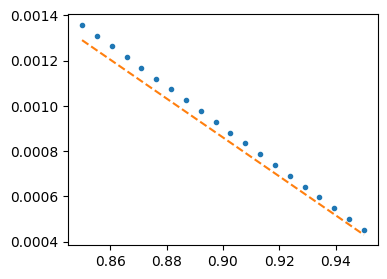

In [304]:
L2 = 10 # km distance
w1_list = np.linspace(0.85,0.95,20) # mesh grid optimization
w2_list = [0.8]#np.linspace(0.75,0.9,40) # mesh grid optimization
R_list = np.zeros((len(w1_list),len(w2_list)))
R_anal = np.zeros((len(w1_list),len(w2_list)))
q = 0.9
for i_w1, w1 in enumerate(w1_list):              
    for i_w2, w2 in enumerate(w2_list):
        d2 = d(L2,T2)
        p1 = d1*(1-w1_list[i_w1])*T1/10
        p2 = d2*(1-w2_list[i_w2])*T2 
        R_list[i_w1,i_w2] = rate_p(p1,p2)
        R_anal[i_w1,i_w2] = min(p1,p2)* q**2
plt.figure(figsize=(4,3))
plt.plot(w1_list,R_list,".",label="w1")
plt.plot(w1_list,R_anal,"--",label="analytical")
# plt.legend()
plt.show()

In [309]:
q = 0.1
rate_p(0.5,0.4)

0.5
0.4
0.5


0.004000000000000001

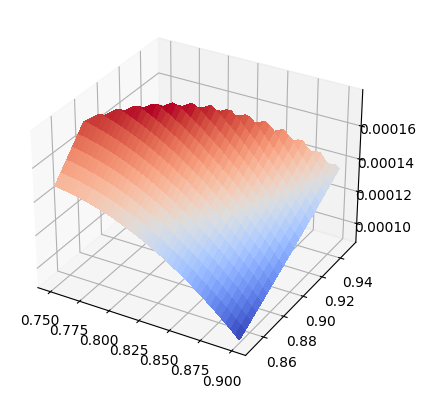

In [230]:

# L2_list = np.linspace(10,300,20) # km distance
L2_list = [20]
w_opt = np.zeros(len(L2_list))
w2_opt = np.zeros(len(L2_list))
U_opt = np.zeros(len(L2_list))
T2 = 1e-4 # sec repetition time for entanglement generation


w1_list = np.linspace(0.85,0.95,20) # mesh grid optimization
# R_list = d1*(1-w1_list)
# w1 = 0.85
# p1 = d1*(1-w1)
w2_list = np.linspace(0.75,0.9,40) # mesh grid optimization
R_list = np.zeros((len(w1_list),len(w2_list)))
q = 0.1
for i_L, L2 in enumerate(L2_list):    
    d2 = d(L2,T2)
    for i_w1, w1 in enumerate(w1_list):              
        for i_w2, w2 in enumerate(w2_list):
            R_list[i_w1,i_w2] = rate_w([w1,w2])
#     plt.plot(w2_list,R_list.T,".-")
#     log_arg = R*(3* w1**2 *w2 - 1)    
#     w1_grid = w1[log_arg>0]
# #     print(np.size(w1_grid),L2)
#     log_arg = log_arg[log_arg>0]
#     U_neg = np.log(log_arg)

# #     log_arg = R*(1-2*entropy((1-w1**2 * w2)/2) ) # SKF
#     log_arg = R*D_H((3* w1**2 *w2 + 1)/4 )
# #     log_arg = R*(3* w1**2 *w2 - 1) # log neg
#     w1_grid = w1[log_arg>0]
#     log_arg = log_arg[log_arg>0]
#     U_neg = np.log(log_arg)
# #     print(len(U_neg))
#     ind_opt = np.argmax(U_neg)
#     w_opt[i_L] = w1_grid[ind_opt]
#     w2_opt[i_L] = 1- d1/d2*(1-w_opt[i_L])
#     U_opt[i_L] = U_neg[ind_opt]
# #     R_opt = d1* (1-w_opt[i_L])
# #     plt.plot((3*w1_grid+1)/4,U_neg)
# #     plt.plot((3*w_opt[i_L]+1)/4,U_opt,"o")


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(w2_list, w1_list)

log_arg = R_list*(3* Y**2 *X - 1)    

surf = ax.plot_surface(X, Y, log_arg, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# # Customize the z axis.
# # ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# plt.figure(figsize=(4,3))
# # plt.plot(L2_list,w_opt,".-",label="w1")
# # plt.plot(L2_list,w2_opt,".-",label="w2")
# plt.plot(L2_list,(3*w_opt+1)/4,".-",label="w1")
# plt.plot(L2_list,(3*w2_opt+1)/4,".-",label="w2")
# plt.plot(L2_list,(3*w_opt**2 * w2_opt+1)/4,".-",label="we2e")
# plt.legend()
# plt.show()

# plt.figure(figsize=(4,3))
# plt.plot(L2_list,U_opt,".-")
# plt.show()

# print("opt link fidelity: ", (3*w_opt[i_L]+1)/4)
# print("opt utility:", U_opt)
# print("opt rate:", R_opt)


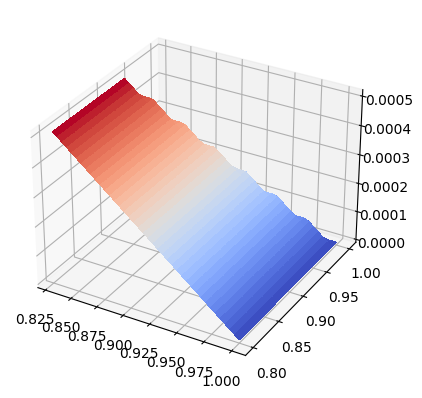

In [109]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
   
surf = ax.plot_surface(X, Y, R_list, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


Text(0, 0.5, 'F1')

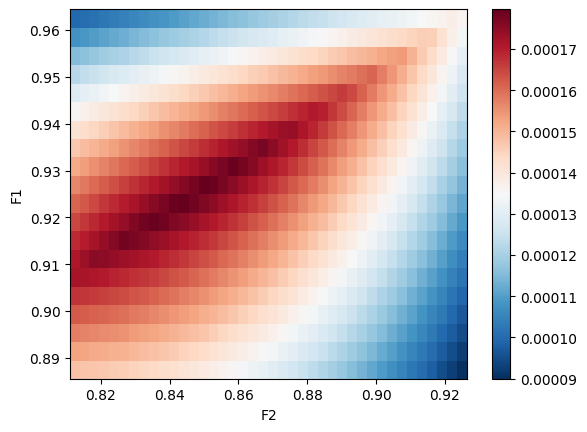

In [231]:
plt.pcolor((1+3*X)/4, (1+3*Y)/4, log_arg, cmap='RdBu_r')#, vmin=z_min, vmax=z_max)
plt.colorbar()
plt.xlabel("F2")
plt.ylabel("F1")


In [232]:
i1, i2 = np.unravel_index(np.argmax(log_arg, axis=None), log_arg.shape)
print((1+3*w1_list[i1])/4,(1+3*w2_list[i2])/4)

0.9230263157894737 0.8442307692307692


In [261]:
# from scipy.optimize import fmin
# w1_opt, w2_opt  = fmin(QNUM,np.array([0.9,0.9]))

# print((1+3*w1_opt)/4,(1+3*w2_opt)/4)
QNUM(w_guess)

[0.8 0.8]
0.00018928720334405796


-0.00010145794099241516

20.0
Optimization terminated successfully.
         Current function value: -0.000033
         Iterations: 52
         Function evaluations: 92
65.0
Optimization terminated successfully.
         Current function value: -0.000028
         Iterations: 47
         Function evaluations: 86
110.0
Optimization terminated successfully.
         Current function value: -0.000020
         Iterations: 47
         Function evaluations: 87
155.0
Optimization terminated successfully.
         Current function value: -0.000011
         Iterations: 60
         Function evaluations: 108
200.0
Optimization terminated successfully.
         Current function value: -0.000005
         Iterations: 42
         Function evaluations: 81


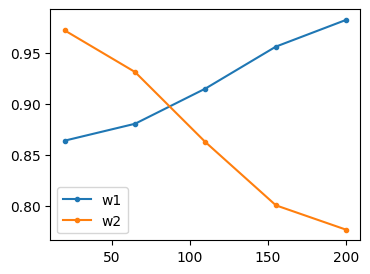

In [278]:
from scipy.optimize import fsolve, fmin_cobyla, fmin

def constr1(x):
    return x[0]-0.5, 1-x[0], x[1]-0.5, 1-x[1]

def constr2(x):
    return x[1]-0.5, 1-x[1]

def constr3(x):
    return x[1]-0.5

def constr4(x):
    return 1-x[1]

L2_list = np.linspace(20,200,5) # km distance
w1_opt = np.zeros(len(L2_list))
w2_opt = np.zeros(len(L2_list))
U_opt = np.zeros(len(L2_list))
q = 0.1
for i_L, L2 in enumerate(L2_list):    
    print(L2)
    d2 = d(L2,T2)
    
    w_guess = 0.8* np.array([1,1])
    w1_opt[i_L], w2_opt[i_L] = fmin(QNUM,w_guess)
#     w1_opt[i_L], w2_opt[i_L] = fmin_cobyla(QNUM, w_guess, constr1)#, rhoend=1e-3)

plt.figure(figsize=(4,3))
# plt.plot(L2_list,w_opt,".-",label="w1")
# plt.plot(L2_list,w2_opt,".-",label="w2")
plt.plot(L2_list,(3*w1_opt+1)/4,".-",label="w1")
plt.plot(L2_list,(3*w2_opt+1)/4,".-",label="w2")
# plt.plot(L2_list,(3*w_opt**2 * w2_opt+1)/4,".-",label="we2e")
plt.legend()
plt.show()

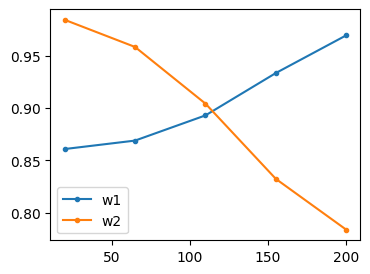

In [277]:
plt.figure(figsize=(4,3))
# plt.plot(L2_list,w_opt,".-",label="w1")
# plt.plot(L2_list,w2_opt,".-",label="w2")
plt.plot(L2_list,(3*w1_opt+1)/4,".-",label="w1")
plt.plot(L2_list,(3*w2_opt+1)/4,".-",label="w2")
# plt.plot(L2_list,(3*w_opt**2 * w2_opt+1)/4,".-",label="we2e")
plt.legend()
plt.show()

In [194]:
i1, i2 = np.unravel_index(np.argmax(log_arg, axis=None), log_arg.shape)
print((1+3*w1_list[i1])/4,(1+3*w2_list[i2])/4)

0.7986842105263158 0.9769230769230769


Text(0, 0.5, 'F1')

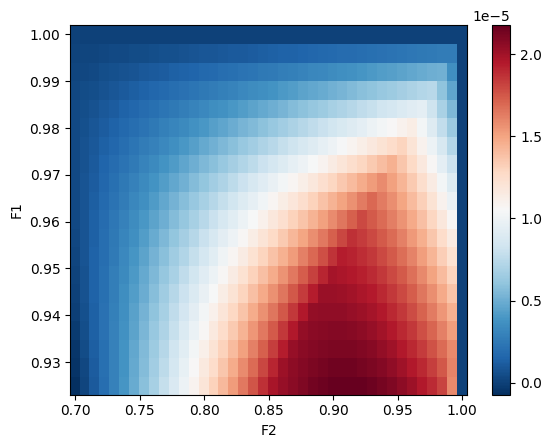

In [183]:
plt.pcolor((1+3*X)/4, (1+3*Y)/4, log_arg, cmap='RdBu_r')#, vmin=z_min, vmax=z_max)
plt.colorbar()
plt.xlabel("F2")
plt.ylabel("F1")


In [184]:
i1, i2 = np.unravel_index(np.argmax(log_arg, axis=None), log_arg.shape)
print((1+3*w1_list[i1])/4,(1+3*w2_list[i2])/4)

0.925 0.9076923076923077


In [153]:
i1, i2 = np.unravel_index(np.argmax(log_arg, axis=None), log_arg.shape)
print(w1_list[i1],w2_list[i2])

0.9842105263157894 0.8051282051282052
